## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp008'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext50_32x4d'
    #backbone = 'se_resnext101_32x4d'
    backbone = 'se_resnet152'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 3 #1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

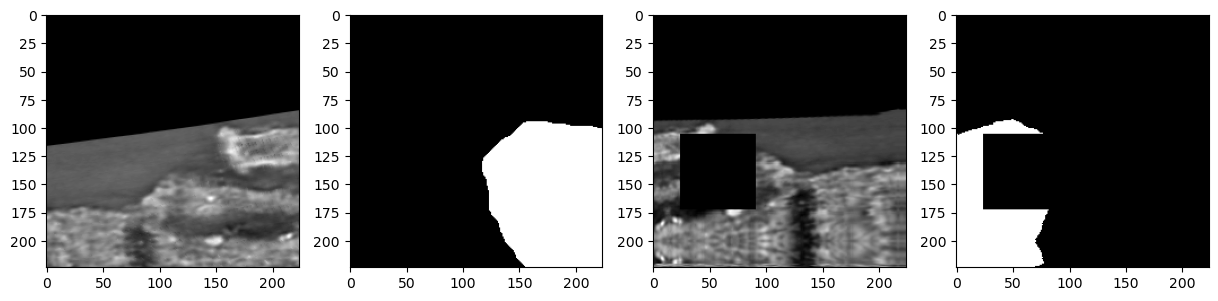

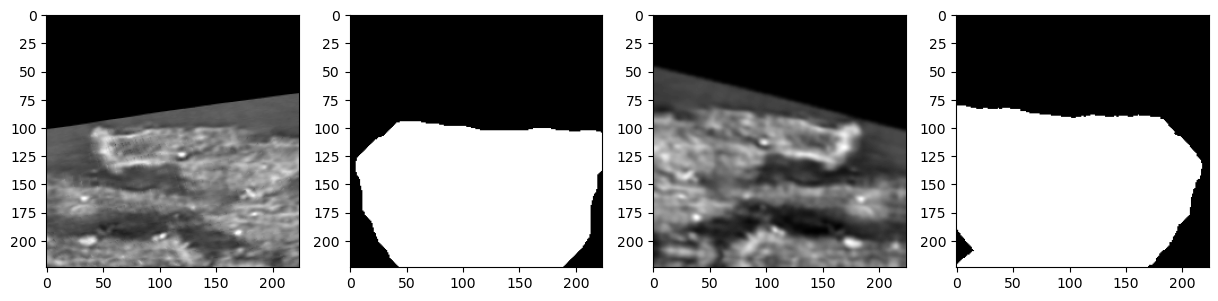

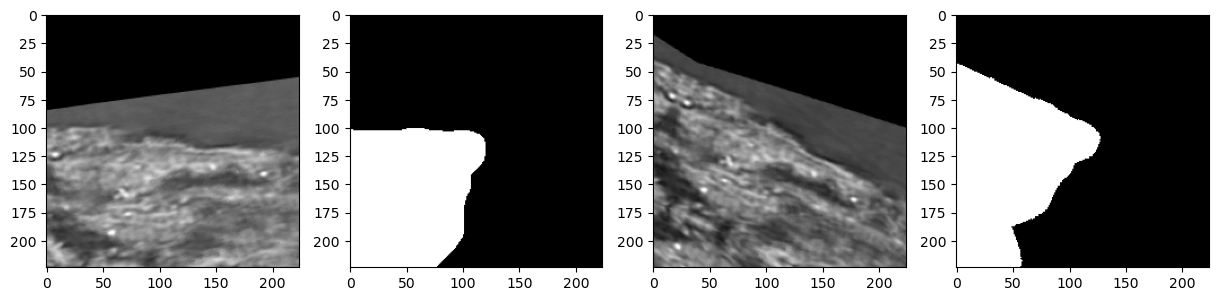

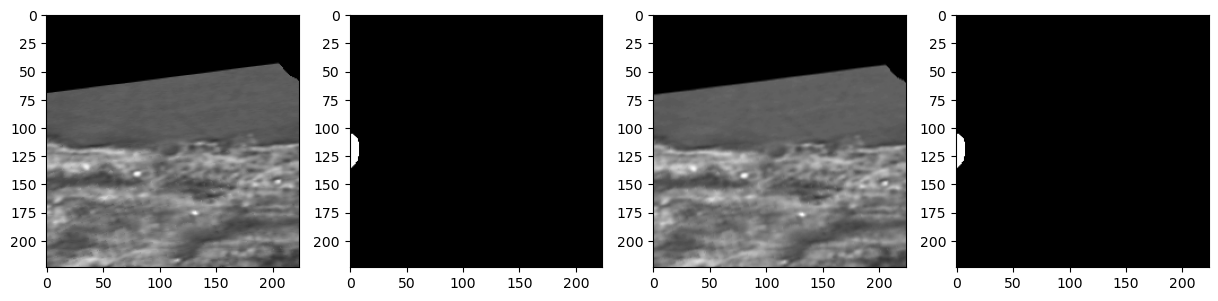

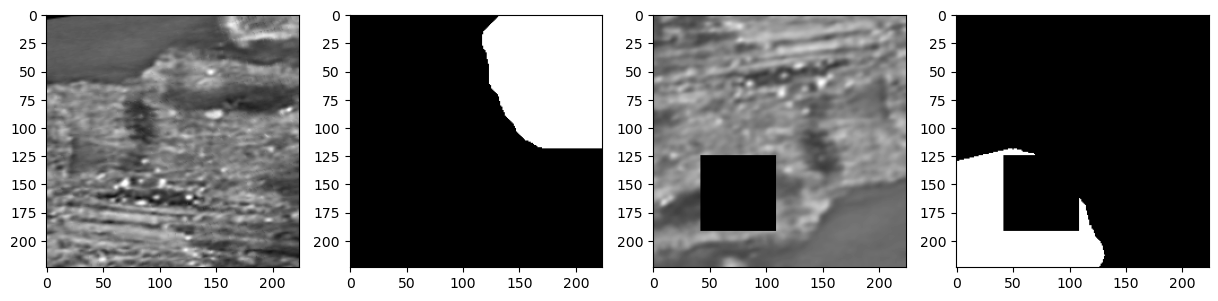

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

48110

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnet152


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.09501427423092888
th: 0.15, fbeta: 0.09504633522978469
th: 0.2, fbeta: 0.14237215964304378
th: 0.25, fbeta: 0.14997175001260882
th: 0.3, fbeta: 0.16853457098749194
th: 0.35, fbeta: 0.23301840772214222
th: 0.4, fbeta: 0.31464252793984987
th: 0.45, fbeta: 0.37819890468694023


best_th: 0.5, fbeta: 0.4149873944861104
Epoch 1 - avg_train_loss: 0.6092  avg_val_loss: 0.4004  time: 266s
Epoch 1 - avgScore: 0.4150
Epoch 1 - Save Best Score: 0.4150 Model
Epoch 1 - Save Best Loss: 0.4004 Model


th: 0.5, fbeta: 0.4149873944861104


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.09559714644733322
th: 0.15, fbeta: 0.1536698316763779
th: 0.2, fbeta: 0.16031524181619097
th: 0.25, fbeta: 0.22976024381813648
th: 0.3, fbeta: 0.31561411155523544
th: 0.35, fbeta: 0.37325160993083006
th: 0.4, fbeta: 0.4110278042817942
th: 0.45, fbeta: 0.4406744223023602


best_th: 0.5, fbeta: 0.46202761022364486
Epoch 2 - avg_train_loss: 0.3749  avg_val_loss: 0.3198  time: 267s
Epoch 2 - avgScore: 0.4620
Epoch 2 - Save Best Score: 0.4620 Model
Epoch 2 - Save Best Loss: 0.3198 Model


th: 0.5, fbeta: 0.46202761022364486


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.1934915845058895
th: 0.15, fbeta: 0.27862999243765574
th: 0.2, fbeta: 0.35432674120443186
th: 0.25, fbeta: 0.40054089684704397
th: 0.3, fbeta: 0.42077397119132526
th: 0.35, fbeta: 0.43036226035965436
th: 0.4, fbeta: 0.4251630894472241
th: 0.45, fbeta: 0.4007730075695852


best_th: 0.35, fbeta: 0.43036226035965436
Epoch 3 - avg_train_loss: 0.2874  avg_val_loss: 0.2150  time: 269s
Epoch 3 - avgScore: 0.4304


th: 0.5, fbeta: 0.3291460808310197


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34711313693104034
th: 0.15, fbeta: 0.4227178451907477
th: 0.2, fbeta: 0.47223550648349233
th: 0.25, fbeta: 0.49636633027565463
th: 0.3, fbeta: 0.5067676428550012
th: 0.35, fbeta: 0.5028738768110533
th: 0.4, fbeta: 0.49341039734758396
th: 0.45, fbeta: 0.4761125261709377


best_th: 0.3, fbeta: 0.5067676428550012
Epoch 4 - avg_train_loss: 0.2558  avg_val_loss: 0.1971  time: 268s
Epoch 4 - avgScore: 0.5068
Epoch 4 - Save Best Score: 0.5068 Model
Epoch 4 - Save Best Loss: 0.1971 Model


th: 0.5, fbeta: 0.44932834495163787


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2684125119790164
th: 0.15, fbeta: 0.317112388483292
th: 0.2, fbeta: 0.3646730177827293
th: 0.25, fbeta: 0.4083689869337239
th: 0.3, fbeta: 0.44875254099369166
th: 0.35, fbeta: 0.4816448893420519
th: 0.4, fbeta: 0.5096368980087864
th: 0.45, fbeta: 0.5307467872945386


best_th: 0.5, fbeta: 0.5475265139806678
Epoch 5 - avg_train_loss: 0.2469  avg_val_loss: 0.1939  time: 268s
Epoch 5 - avgScore: 0.5475
Epoch 5 - Save Best Score: 0.5475 Model
Epoch 5 - Save Best Loss: 0.1939 Model


th: 0.5, fbeta: 0.5475265139806678


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.19814604329321403
th: 0.15, fbeta: 0.22135473952374587
th: 0.2, fbeta: 0.2419391600804927
th: 0.25, fbeta: 0.26246995970157755
th: 0.3, fbeta: 0.2840276482408617
th: 0.35, fbeta: 0.30578971466725396
th: 0.4, fbeta: 0.3290427556305051
th: 0.45, fbeta: 0.3534403473781238


best_th: 0.5, fbeta: 0.3791765265272484
Epoch 6 - avg_train_loss: 0.2392  avg_val_loss: 0.2784  time: 271s
Epoch 6 - avgScore: 0.3792


th: 0.5, fbeta: 0.3791765265272484


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.22699173712381507
th: 0.15, fbeta: 0.29038037131583616
th: 0.2, fbeta: 0.3534430848137375
th: 0.25, fbeta: 0.41172115661844494
th: 0.3, fbeta: 0.46003818972710314
th: 0.35, fbeta: 0.4981512095460549
th: 0.4, fbeta: 0.5244248235519275
th: 0.45, fbeta: 0.544312789978141


best_th: 0.5, fbeta: 0.5587968918218978
Epoch 7 - avg_train_loss: 0.2315  avg_val_loss: 0.1970  time: 267s
Epoch 7 - avgScore: 0.5588
Epoch 7 - Save Best Score: 0.5588 Model
Epoch 7 - Save Best Loss: 0.1970 Model


th: 0.5, fbeta: 0.5587968918218978


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.20270877955031202
th: 0.15, fbeta: 0.2259497730765441
th: 0.2, fbeta: 0.24510699163444835
th: 0.25, fbeta: 0.26573845615923974
th: 0.3, fbeta: 0.28917650470627104
th: 0.35, fbeta: 0.314620861370108
th: 0.4, fbeta: 0.3413789255754587
th: 0.45, fbeta: 0.37306018314161016


best_th: 0.5, fbeta: 0.4062933778948257
Epoch 8 - avg_train_loss: 0.2275  avg_val_loss: 0.2562  time: 269s
Epoch 8 - avgScore: 0.4063


th: 0.5, fbeta: 0.4062933778948257


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.28203597182429174
th: 0.15, fbeta: 0.32783014959493134
th: 0.2, fbeta: 0.3649419734118313
th: 0.25, fbeta: 0.39898515804629836
th: 0.3, fbeta: 0.43309143507233505
th: 0.35, fbeta: 0.4618277432037256
th: 0.4, fbeta: 0.48829028899445404
th: 0.45, fbeta: 0.5093375287163666


best_th: 0.5, fbeta: 0.5267478333258103
Epoch 9 - avg_train_loss: 0.2196  avg_val_loss: 0.2037  time: 270s
Epoch 9 - avgScore: 0.5267


th: 0.5, fbeta: 0.5267478333258103


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2675735297456921
th: 0.15, fbeta: 0.2977556921371171
th: 0.2, fbeta: 0.3225963637980854
th: 0.25, fbeta: 0.3460468159170929
th: 0.3, fbeta: 0.3684430445865351
th: 0.35, fbeta: 0.3886444723243633
th: 0.4, fbeta: 0.4091101461930439
th: 0.45, fbeta: 0.42851431704020077


best_th: 0.5, fbeta: 0.44767583683655016
Epoch 10 - avg_train_loss: 0.2145  avg_val_loss: 0.2361  time: 269s
Epoch 10 - avgScore: 0.4477


th: 0.5, fbeta: 0.44767583683655016


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.27757405112385547
th: 0.15, fbeta: 0.3334042882305923
th: 0.2, fbeta: 0.38830184320844924
th: 0.25, fbeta: 0.4385462840016759
th: 0.3, fbeta: 0.47653141619303907
th: 0.35, fbeta: 0.5056419044902924
th: 0.4, fbeta: 0.5297342019988568
th: 0.45, fbeta: 0.5501447400509555


best_th: 0.5, fbeta: 0.5670884465868026
Epoch 11 - avg_train_loss: 0.2098  avg_val_loss: 0.1914  time: 272s
Epoch 11 - avgScore: 0.5671
Epoch 11 - Save Best Score: 0.5671 Model
Epoch 11 - Save Best Loss: 0.1914 Model


th: 0.5, fbeta: 0.5670884465868026


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2264204753896801
th: 0.15, fbeta: 0.25265313214165397
th: 0.2, fbeta: 0.2730103153138607
th: 0.25, fbeta: 0.2932203214344454
th: 0.3, fbeta: 0.31253948753217736
th: 0.35, fbeta: 0.3320515510883537
th: 0.4, fbeta: 0.3530845801126479
th: 0.45, fbeta: 0.3742473692461612


best_th: 0.5, fbeta: 0.3955775646791321
Epoch 12 - avg_train_loss: 0.2028  avg_val_loss: 0.3008  time: 272s
Epoch 12 - avgScore: 0.3956


th: 0.5, fbeta: 0.3955775646791321


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.25028716351269237
th: 0.15, fbeta: 0.2870157920659447
th: 0.2, fbeta: 0.3206512343398581
th: 0.25, fbeta: 0.35136723358433763
th: 0.3, fbeta: 0.3816746523454687
th: 0.35, fbeta: 0.4116434442892598
th: 0.4, fbeta: 0.4402846711670979
th: 0.45, fbeta: 0.4725786267571281


best_th: 0.5, fbeta: 0.5038847076560862
Epoch 13 - avg_train_loss: 0.1938  avg_val_loss: 0.2122  time: 267s
Epoch 13 - avgScore: 0.5039


th: 0.5, fbeta: 0.5038847076560862


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3224703169664977
th: 0.15, fbeta: 0.36765646630061344
th: 0.2, fbeta: 0.4049222604752104
th: 0.25, fbeta: 0.4380744294393781
th: 0.3, fbeta: 0.46356448541732387
th: 0.35, fbeta: 0.4843281788353355
th: 0.4, fbeta: 0.5027457874405143
th: 0.45, fbeta: 0.5169554614585622


best_th: 0.5, fbeta: 0.5282121686842114
Epoch 14 - avg_train_loss: 0.1861  avg_val_loss: 0.2121  time: 271s
Epoch 14 - avgScore: 0.5282


th: 0.5, fbeta: 0.5282121686842114


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2802260345882417
th: 0.15, fbeta: 0.3273598608481127
th: 0.2, fbeta: 0.3678722464925797
th: 0.25, fbeta: 0.39906424622424214
th: 0.3, fbeta: 0.4246310120754436
th: 0.35, fbeta: 0.44948592614360144
th: 0.4, fbeta: 0.47309820816404924
th: 0.45, fbeta: 0.496617897898052


best_th: 0.5, fbeta: 0.5164837750090395
Epoch 15 - avg_train_loss: 0.1815  avg_val_loss: 0.2051  time: 270s
Epoch 15 - avgScore: 0.5165


th: 0.5, fbeta: 0.5164837750090395


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.19325564218573715
th: 0.15, fbeta: 0.2064283164940958
th: 0.2, fbeta: 0.2188232009679867
th: 0.25, fbeta: 0.2315975167344433
th: 0.3, fbeta: 0.24688685387187953
th: 0.35, fbeta: 0.26317476481577623
th: 0.4, fbeta: 0.2820437917425249
th: 0.45, fbeta: 0.30202793843512415


best_th: 0.5, fbeta: 0.3223984665060018
Epoch 16 - avg_train_loss: 0.1746  avg_val_loss: 0.3997  time: 272s
Epoch 16 - avgScore: 0.3224


th: 0.5, fbeta: 0.3223984665060018


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2883162481050401
th: 0.15, fbeta: 0.33268752946914626
th: 0.2, fbeta: 0.3734658321645094
th: 0.25, fbeta: 0.408429552577812
th: 0.3, fbeta: 0.4378664474583252
th: 0.35, fbeta: 0.4628697544572337
th: 0.4, fbeta: 0.48758254625926756
th: 0.45, fbeta: 0.5085581864907318


best_th: 0.5, fbeta: 0.526667532222852
Epoch 17 - avg_train_loss: 0.1651  avg_val_loss: 0.2069  time: 269s
Epoch 17 - avgScore: 0.5267


th: 0.5, fbeta: 0.526667532222852


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2660797837976968
th: 0.15, fbeta: 0.3036644464421479
th: 0.2, fbeta: 0.33722567873698883
th: 0.25, fbeta: 0.3690912092775816
th: 0.3, fbeta: 0.3990394426306305
th: 0.35, fbeta: 0.42992982692208
th: 0.4, fbeta: 0.4592428566914043
th: 0.45, fbeta: 0.4862310142708883


best_th: 0.5, fbeta: 0.5104583523118283
Epoch 18 - avg_train_loss: 0.1602  avg_val_loss: 0.2225  time: 270s
Epoch 18 - avgScore: 0.5105


th: 0.5, fbeta: 0.5104583523118283


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2561500038441942
th: 0.15, fbeta: 0.2852342509702441
th: 0.2, fbeta: 0.31474223824573594
th: 0.25, fbeta: 0.343571804052183
th: 0.3, fbeta: 0.37202515127780567
th: 0.35, fbeta: 0.39906621565370554
th: 0.4, fbeta: 0.4242044542523987
th: 0.45, fbeta: 0.4493992059378477


best_th: 0.5, fbeta: 0.4732590472549523
Epoch 19 - avg_train_loss: 0.1546  avg_val_loss: 0.2479  time: 275s
Epoch 19 - avgScore: 0.4733


th: 0.5, fbeta: 0.4732590472549523


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2454578804272966
th: 0.15, fbeta: 0.2668232597964232
th: 0.2, fbeta: 0.28680347179042887
th: 0.25, fbeta: 0.3066507210509549
th: 0.3, fbeta: 0.3260047810033283
th: 0.35, fbeta: 0.3458815808155278
th: 0.4, fbeta: 0.36571640014022616
th: 0.45, fbeta: 0.3843991560325259


best_th: 0.5, fbeta: 0.4032286212104686
Epoch 20 - avg_train_loss: 0.1461  avg_val_loss: 0.3164  time: 271s
Epoch 20 - avgScore: 0.4032


th: 0.5, fbeta: 0.4032286212104686


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2612302827868738
th: 0.15, fbeta: 0.29187603542933
th: 0.2, fbeta: 0.3221109253149684
th: 0.25, fbeta: 0.3511745921649551
th: 0.3, fbeta: 0.37881084785608515
th: 0.35, fbeta: 0.4051638592016926
th: 0.4, fbeta: 0.43006768100871684
th: 0.45, fbeta: 0.45031803971977075


best_th: 0.5, fbeta: 0.4693241948290469
Epoch 21 - avg_train_loss: 0.1425  avg_val_loss: 0.2394  time: 269s
Epoch 21 - avgScore: 0.4693


th: 0.5, fbeta: 0.4693241948290469


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.27636489215010573
th: 0.15, fbeta: 0.3106739566958145
th: 0.2, fbeta: 0.34128371626512627
th: 0.25, fbeta: 0.36884713092853755
th: 0.3, fbeta: 0.39376105549874485
th: 0.35, fbeta: 0.4164235225264499
th: 0.4, fbeta: 0.4377988283303835
th: 0.45, fbeta: 0.456333419419385


best_th: 0.5, fbeta: 0.47634493575662007
Epoch 22 - avg_train_loss: 0.1351  avg_val_loss: 0.2542  time: 271s
Epoch 22 - avgScore: 0.4763


th: 0.5, fbeta: 0.47634493575662007


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.30477161155797666
th: 0.15, fbeta: 0.34506289204606705
th: 0.2, fbeta: 0.38063258229856073
th: 0.25, fbeta: 0.412048586599471
th: 0.3, fbeta: 0.44009206918092203
th: 0.35, fbeta: 0.46556478227946624
th: 0.4, fbeta: 0.488011879960061
th: 0.45, fbeta: 0.506037756077094


best_th: 0.5, fbeta: 0.5199321527046858
Epoch 23 - avg_train_loss: 0.1312  avg_val_loss: 0.2293  time: 274s
Epoch 23 - avgScore: 0.5199


th: 0.5, fbeta: 0.5199321527046858


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.28736731844263147
th: 0.15, fbeta: 0.32474583164077525
th: 0.2, fbeta: 0.3568644782220195
th: 0.25, fbeta: 0.3863863718250511
th: 0.3, fbeta: 0.4123638789579967
th: 0.35, fbeta: 0.4364337784147219
th: 0.4, fbeta: 0.45896734959759855
th: 0.45, fbeta: 0.4789800847982047


best_th: 0.5, fbeta: 0.4952240188543869
Epoch 24 - avg_train_loss: 0.1257  avg_val_loss: 0.2454  time: 274s
Epoch 24 - avgScore: 0.4952


th: 0.5, fbeta: 0.4952240188543869


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2849875569813285
th: 0.15, fbeta: 0.322134053665508
th: 0.2, fbeta: 0.3559957800144835
th: 0.25, fbeta: 0.38609377585589466
th: 0.3, fbeta: 0.4123854448405674
th: 0.35, fbeta: 0.4361620802712214
th: 0.4, fbeta: 0.45851074725390406
th: 0.45, fbeta: 0.4771556747483489


best_th: 0.5, fbeta: 0.492624870131397
Epoch 25 - avg_train_loss: 0.1213  avg_val_loss: 0.2427  time: 269s
Epoch 25 - avgScore: 0.4926


th: 0.5, fbeta: 0.492624870131397


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.29040520201422687
th: 0.15, fbeta: 0.3257378118739252
th: 0.2, fbeta: 0.35727659467680334
th: 0.25, fbeta: 0.3838969413006594
th: 0.3, fbeta: 0.40755040999626363
th: 0.35, fbeta: 0.43054540819865095
th: 0.4, fbeta: 0.452838822552133
th: 0.45, fbeta: 0.474736686995323


best_th: 0.5, fbeta: 0.4921184947072194
Epoch 26 - avg_train_loss: 0.1147  avg_val_loss: 0.2458  time: 271s
Epoch 26 - avgScore: 0.4921


th: 0.5, fbeta: 0.4921184947072194


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.26959308219093603
th: 0.15, fbeta: 0.29875226869022836
th: 0.2, fbeta: 0.3250778610551402
th: 0.25, fbeta: 0.3481719376714397
th: 0.3, fbeta: 0.3700541172996397
th: 0.35, fbeta: 0.39350227360971424
th: 0.4, fbeta: 0.4160598418080796
th: 0.45, fbeta: 0.43694047609075837


best_th: 0.5, fbeta: 0.4551390763866113
Epoch 27 - avg_train_loss: 0.1146  avg_val_loss: 0.2747  time: 272s
Epoch 27 - avgScore: 0.4551


th: 0.5, fbeta: 0.4551390763866113


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2987207795029611
th: 0.15, fbeta: 0.3325464003353287
th: 0.2, fbeta: 0.36234623962557094
th: 0.25, fbeta: 0.3901429571542923
th: 0.3, fbeta: 0.4151221755512151
th: 0.35, fbeta: 0.4388083924208522
th: 0.4, fbeta: 0.4592487794470529
th: 0.45, fbeta: 0.4767573308893617


best_th: 0.5, fbeta: 0.492553276433317
Epoch 28 - avg_train_loss: 0.1108  avg_val_loss: 0.2496  time: 270s
Epoch 28 - avgScore: 0.4926


th: 0.5, fbeta: 0.492553276433317


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2882960110169444
th: 0.15, fbeta: 0.31941069082504425
th: 0.2, fbeta: 0.34658179678310475
th: 0.25, fbeta: 0.3701804335717741
th: 0.3, fbeta: 0.3932208051758124
th: 0.35, fbeta: 0.4153381573612877
th: 0.4, fbeta: 0.4353415394020765
th: 0.45, fbeta: 0.45386037476889146


best_th: 0.5, fbeta: 0.47128299297346044
Epoch 29 - avg_train_loss: 0.1103  avg_val_loss: 0.2627  time: 269s
Epoch 29 - avgScore: 0.4713


th: 0.5, fbeta: 0.47128299297346044


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.29307589463676653
th: 0.15, fbeta: 0.3263902509123634
th: 0.2, fbeta: 0.3549339589489142
th: 0.25, fbeta: 0.3824475501855671
th: 0.3, fbeta: 0.40633429787333303
th: 0.35, fbeta: 0.4289880762459751
th: 0.4, fbeta: 0.44978205538067645
th: 0.45, fbeta: 0.46903947194370393


best_th: 0.5, fbeta: 0.48568299769471424
Epoch 30 - avg_train_loss: 0.1084  avg_val_loss: 0.2547  time: 272s
Epoch 30 - avgScore: 0.4857


th: 0.5, fbeta: 0.48568299769471424


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.27757405112385547
th: 0.15, fbeta: 0.3334042882305923
th: 0.2, fbeta: 0.38830184320844924
th: 0.25, fbeta: 0.4385462840016759
th: 0.3, fbeta: 0.47653141619303907
th: 0.35, fbeta: 0.5056419044902924
th: 0.4, fbeta: 0.5297342019988568
th: 0.45, fbeta: 0.5501447400509555


best_th: 0.5, fbeta: 0.5670884465868026


th: 0.5, fbeta: 0.5670884465868026


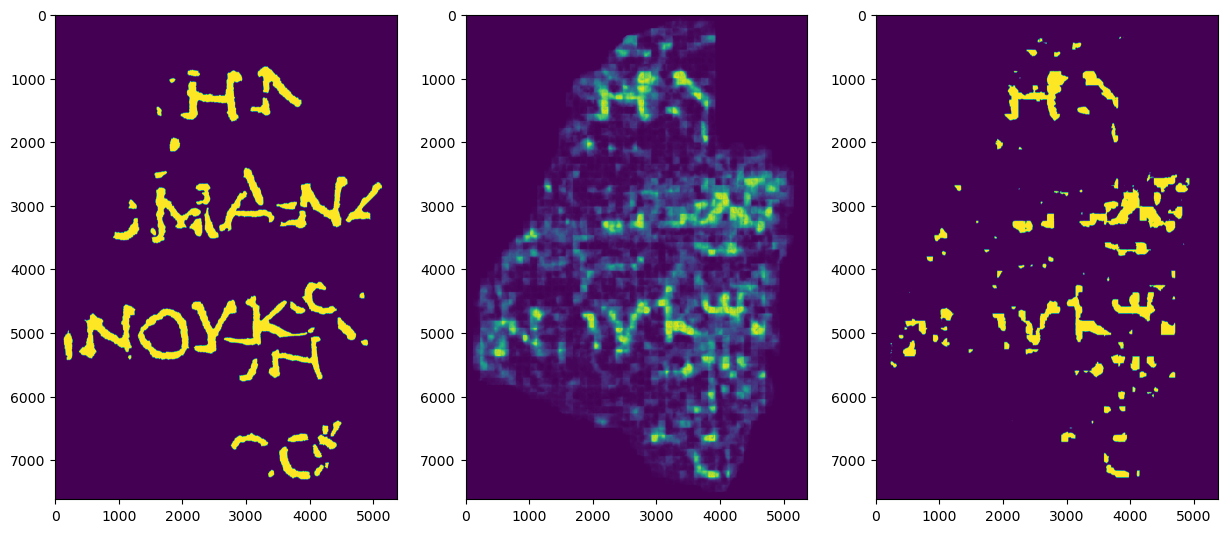

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([2.5628643e+07, 4.0282230e+06, 2.7800500e+06, 1.9499770e+06,
        1.3807420e+06, 9.5709300e+05, 6.9150200e+05, 5.5039000e+05,
        4.3187600e+05, 3.6731100e+05, 3.1858500e+05, 2.7628300e+05,
        2.4304200e+05, 2.2644600e+05, 2.1941000e+05, 2.3697300e+05,
        2.4231300e+05, 2.6095000e+05, 1.3773500e+05, 1.6072000e+04]),
 array([8.40029291e-09, 4.83929490e-02, 9.67858897e-02, 1.45178830e-01,
        1.93571771e-01, 2.41964712e-01, 2.90357652e-01, 3.38750593e-01,
        3.87143534e-01, 4.35536474e-01, 4.83929415e-01, 5.32322355e-01,
        5.80715296e-01, 6.29108237e-01, 6.77501177e-01, 7.25894118e-01,
        7.74287059e-01, 8.22679999e-01, 8.71072940e-01, 9.19465881e-01,
        9.67858821e-01]),
 <BarContainer object of 20 artists>)

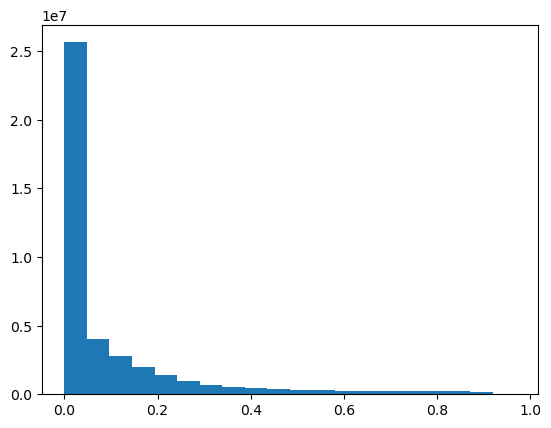

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000